# Data Science for Transport Planning and Analytics
## Session 1: Data Collection and Processing

This notebook demonstrates how to collect, process, and analyze transport-related datasets including:
- OpenStreetMap data (cycleways, amenities)
- STATS19 road traffic collision data
- PCT (Propensity to Cycle Tool) desire lines
- Administrative boundaries


In [7]:
# Import required libraries
import osmnx as ox
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import requests
import zipfile
import os
from io import BytesIO
from pathlib import Path
import pickle
from shapely.geometry import Point

# Set up plotting
plt.style.use('default')
%matplotlib inline


In [29]:
# Create data directory and caching functions
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

def load_or_download_osm(place, tags, filename, geom_types=None):
    """Load cached OSM data or download if not exists"""
    cache_file = DATA_DIR / f"{filename}.geojson"
    
    if cache_file.exists():
        gdf = gpd.read_file(cache_file)
    else:
        gdf = ox.features_from_place(place, tags=tags)
        
        # Filter geometry types if specified
        if geom_types:
            gdf = gdf[gdf.geom_type.isin(geom_types)]
        
        # Save to cache
        gdf.to_file(cache_file, driver='GeoJSON')
    
    return gdf

def load_or_download_csv(url, cache_filename, description):
    """Load cached CSV data or download if not exists"""
    cache_file = DATA_DIR / cache_filename
    
    if cache_file.exists():
        df = pd.read_csv(cache_file)
    else:
        try:
            df = pd.read_csv(url)
            df.to_csv(cache_file, index=False)
        except Exception as e:
            return None
    
    return df

def download_stats19_data(year=2020, data_type="collision"):
    """Download STATS19 data from UK government with caching"""
    base_url = "https://data.dft.gov.uk/road-accidents-safety-data"
    
    # Try multiple URL patterns - the format has changed over the years
    possible_filenames = []
    
    if data_type == "collision":
        possible_filenames = [
            f"dft-road-casualty-statistics-collision-{year}.csv",
            f"RoadSafetyData_Accidents_{year}.csv",
            f"Accidents_{year}.csv",
            f"collision-{year}.csv"
        ]
    elif data_type == "casualty":
        possible_filenames = [
            f"dft-road-casualty-statistics-casualty-{year}.csv",
            f"RoadSafetyData_Casualties_{year}.csv", 
            f"Casualties_{year}.csv",
            f"casualty-{year}.csv"
        ]
    elif data_type == "vehicle":
        possible_filenames = [
            f"dft-road-casualty-statistics-vehicle-{year}.csv",
            f"RoadSafetyData_Vehicles_{year}.csv",
            f"Vehicles_{year}.csv", 
            f"vehicle-{year}.csv"
        ]
    
    cache_filename = f"stats19_{data_type}_{year}.csv"
    
    # Try each possible filename until one works
    for filename in possible_filenames:
        url = f"{base_url}/{filename}"
        result = load_or_download_csv(url, cache_filename, f"STATS19 {data_type} ({year})")
        if result is not None:
            return result
    
    return None

def download_pct_data(region="west-yorkshire", layer="lsoa"):
    """
    Download PCT data for a region and layer with caching.
    For LSOA-level commute data, the files are stored in:
    https://github.com/npct/pct-outputs-regional-notR/tree/master/commute/lsoa/{region}
    """
    # Compose the filename and cache path
    cache_file = DATA_DIR / f"pct_{region}_{layer}.geojson"

    if cache_file.exists():
        gdf = gpd.read_file(cache_file)
        return gdf

    # Try the most likely URL for LSOA-level commute data
    possible_urls = [
        f"https://github.com/npct/pct-outputs-regional-notR/raw/master/commute/lsoa/{region}/{layer}.geojson",
        f"https://github.com/npct/pct-outputs-regional-notR/raw/main/commute/lsoa/{region}/{layer}.geojson",
        f"https://github.com/npct/pct-outputs-regional/raw/master/commute/lsoa/{region}/{layer}.geojson",
        f"https://www.pct.bike/regions_data/commute/lsoa/{region}/{layer}.geojson"
    ]
    for url in possible_urls:
        try:
            gdf = gpd.read_file(url)
            gdf.to_file(cache_file, driver='GeoJSON')
            return gdf
        except Exception:
            continue

    return None

def load_lsoa_boundaries():
    """Load LSOA boundaries with fallback locations"""
    data_lsoa_file = DATA_DIR / "lsoa_boundaries.gpkg"
    
    if data_lsoa_file.exists():
        return gpd.read_file(data_lsoa_file)
    
    original_file = "Lower_layer_Super_Output_Areas_Dec_2011_Boundaries_Full_Clipped_BFC_EW_V3_2022_-5365225720680633795.gpkg"
    
    if os.path.exists(original_file):
        lsoa_gdf = gpd.read_file(original_file)
        lsoa_gdf.to_file(data_lsoa_file, driver='GPKG')
        return lsoa_gdf
    
    return None


## 1. OpenStreetMap Data: West Yorkshire Cycleways


Skipping field motor_vehicle:time_off: unsupported OGR type: 10
Skipping field motor_vehicle:time_on: unsupported OGR type: 10


Found 53496 cycleway features


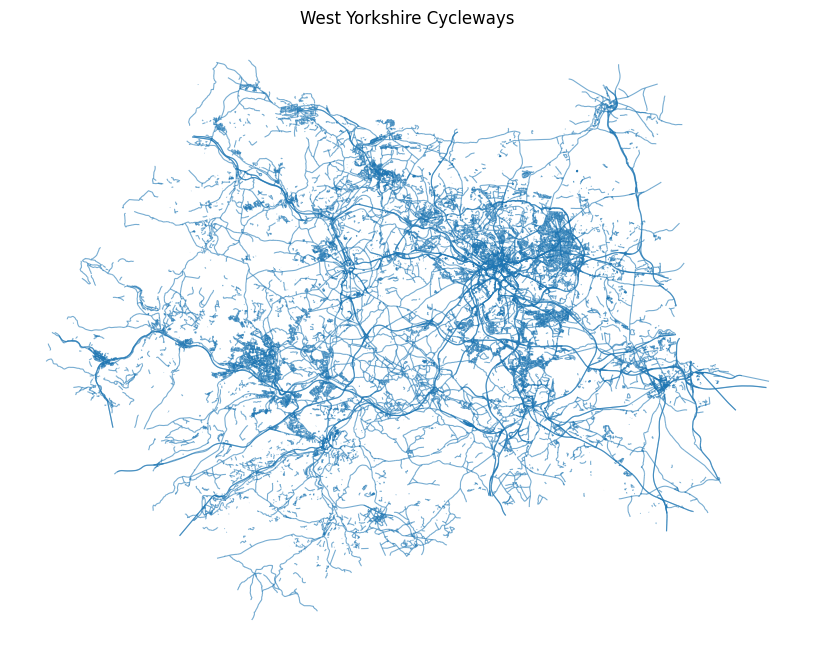

In [9]:
# Download West Yorkshire cycleways
west_yorkshire_cycleways = load_or_download_osm(
    place="West Yorkshire, England",
    tags={"highway": ["cycleway", "path"], "maxspeed": True, "lit": True, "cycleway": True},
    filename="west_yorkshire_cycleways",
    geom_types=["LineString", "MultiLineString"]
)

print(f"Found {len(west_yorkshire_cycleways)} cycleway features")
west_yorkshire_cycleways.plot(figsize=(12, 8), alpha=0.6, linewidth=0.8)
plt.title("West Yorkshire Cycleways")
plt.axis('off')
plt.show()


## 2. OpenStreetMap Data: West Yorkshire Amenities


Found 20598 amenity features


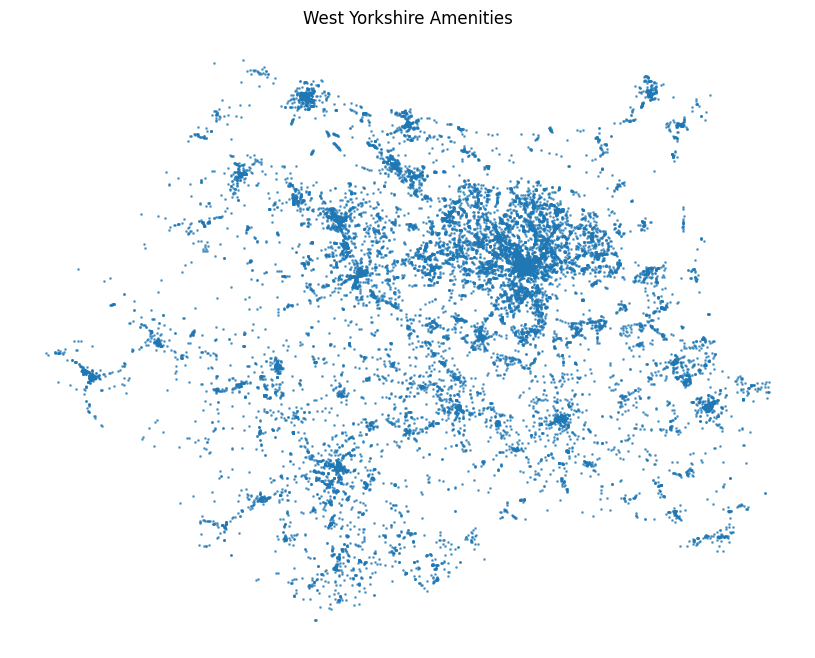


Top 10 amenity types:
amenity
waste_basket       4915
bench              3191
post_box           2549
fast_food          1516
cafe                997
bicycle_parking     748
parking             716
pub                 677
restaurant          623
telephone           452
Name: count, dtype: int64


In [4]:
# Download West Yorkshire amenities  
west_yorkshire_amenities = load_or_download_osm(
    place="West Yorkshire, England",
    tags={"amenity": True},
    filename="west_yorkshire_amenities",
    geom_types=["Point"]
)

print(f"Found {len(west_yorkshire_amenities)} amenity features")

# Plot amenities
west_yorkshire_amenities.plot(figsize=(12, 8), alpha=0.6, markersize=1)
plt.title("West Yorkshire Amenities")
plt.axis('off')
plt.show()

# Show top amenity types
if 'amenity' in west_yorkshire_amenities.columns:
    print("\nTop 10 amenity types:")
    print(west_yorkshire_amenities['amenity'].value_counts().head(10))


## 3. STATS19 Road Traffic Collision Data


In [30]:
# Download STATS19 datasets for 2020
collisions = download_stats19_data(2020, "collision")
casualties = download_stats19_data(2020, "casualty") 
vehicles = download_stats19_data(2020, "vehicle")

# Load PCT desire lines and LSOA boundaries
leeds_desire_lines = download_pct_data("west-yorkshire", "l")
lsoa_boundaries = load_lsoa_boundaries()

# Summary of all datasets
datasets = {
    "West Yorkshire Cycleways": west_yorkshire_cycleways,
    "West Yorkshire Amenities": west_yorkshire_amenities, 
    "STATS19 Collisions": collisions,
    "STATS19 Casualties": casualties,
    "STATS19 Vehicles": vehicles,
    "PCT Desire Lines": leeds_desire_lines,
    "LSOA Boundaries": lsoa_boundaries
}

print("Dataset Summary:")
for name, data in datasets.items():
    if data is not None:
        print(f"✅ {name}: {len(data):,} records")
    else:
        print(f"❌ {name}: Failed to load")


/tmp/ipykernel_125059/817678746.py:28: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cache_file)
/tmp/ipykernel_125059/817678746.py:28: DtypeWarning: Columns (0,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(cache_file)


Dataset Summary:
✅ West Yorkshire Cycleways: 53,496 records
✅ West Yorkshire Amenities: 20,598 records
✅ STATS19 Collisions: 91,199 records
✅ STATS19 Casualties: 115,584 records
✅ STATS19 Vehicles: 167,375 records
✅ PCT Desire Lines: 37,454 records
✅ LSOA Boundaries: 34,753 records


## 4. Data Cleaning: STATS19 Collision Data


Original collision data shape: (91199, 37)
Cleaned collision data shape: (91185, 5)

Sample of cleaned data:


,accident_index,date,speed_limit,accident_severity,geometry
0,2020010219808,04/02/2020,20,3,POINT (521389 175144)
1,2020010220496,27/04/2020,20,3,POINT (529337 176237)
2,2020010228005,01/01/2020,30,3,POINT (526432 182761)
3,2020010228006,01/01/2020,30,2,POINT (538676 184371)
4,2020010228011,01/01/2020,30,3,POINT (529324 181286)


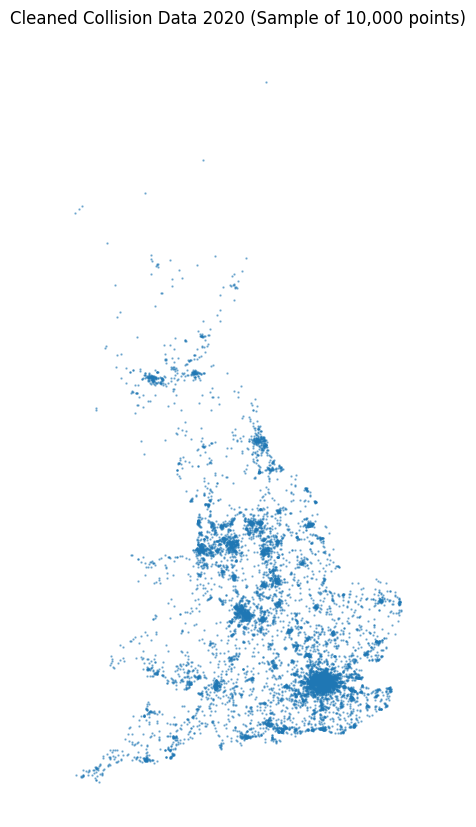


Missing speed limits: 0


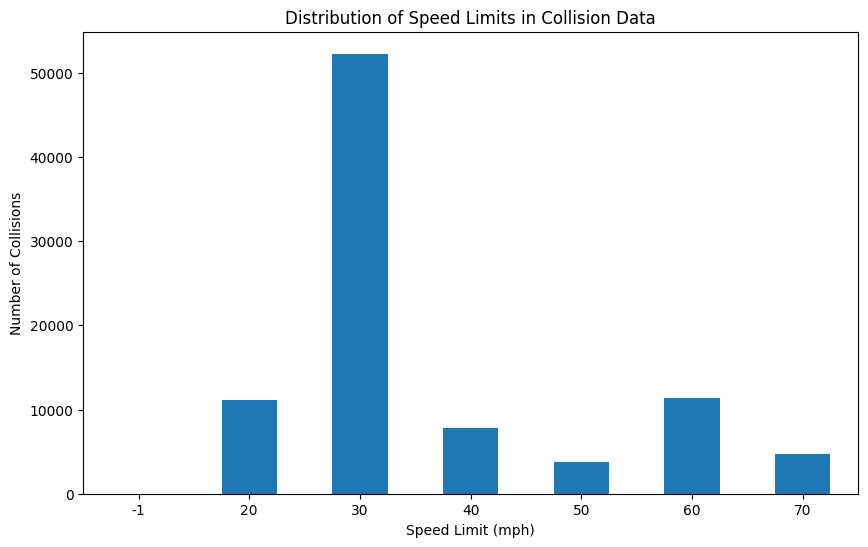

In [25]:
if collisions is not None:
    print("Original collision data shape:", collisions.shape)
    
    # Clean collision data
    collisions_clean = (collisions
        .dropna(subset=['location_easting_osgr', 'location_northing_osgr'])
        [['accident_index', 'date', 'speed_limit', 'accident_severity', 
          'location_easting_osgr', 'location_northing_osgr']]
        .copy()
    )
    
    # Create spatial data
    collisions_clean['geometry'] = collisions_clean.apply(
        lambda row: Point(row['location_easting_osgr'], row['location_northing_osgr']), 
        axis=1
    )
    
    # Convert to GeoDataFrame with British National Grid CRS
    collisions_clean = gpd.GeoDataFrame(
        collisions_clean.drop(['location_easting_osgr', 'location_northing_osgr'], axis=1),
        geometry='geometry',
        crs='EPSG:27700'
    )
    
    print("Cleaned collision data shape:", collisions_clean.shape)
    print("\nSample of cleaned data:")
    display(collisions_clean.head())
    
    # Plot sample of collision points (limit for performance)
    sample_size = min(10000, len(collisions_clean))
    collisions_sample = collisions_clean.sample(n=sample_size)
    
    collisions_sample.plot(figsize=(12, 10), alpha=0.5, markersize=0.5)
    plt.title(f"Cleaned Collision Data 2020 (Sample of {sample_size:,} points)")
    plt.axis('off')
    plt.show()
    
    # Handle missing data in speed limits
    missing_speed_before = collisions_clean['speed_limit'].isnull().sum()
    print(f"\nMissing speed limits: {missing_speed_before:,}")
    
    # Impute missing values using median
    if missing_speed_before > 0:
        median_speed = collisions_clean['speed_limit'].median()
        collisions_clean['speed_limit'] = collisions_clean['speed_limit'].fillna(median_speed)
        print(f"Imputed missing values with median: {median_speed} mph")
    
    # Speed limit distribution
    speed_dist = collisions_clean['speed_limit'].value_counts().sort_index()
    
    plt.figure(figsize=(10, 6))
    speed_dist.plot(kind='bar')
    plt.title('Distribution of Speed Limits in Collision Data')
    plt.xlabel('Speed Limit (mph)')
    plt.ylabel('Number of Collisions')
    plt.xticks(rotation=0)
    plt.show()

else:
    print("No collision data available for cleaning")
    collisions_clean = None


## 4. PCT Desire Lines for West Yorkshire


Found 37454 desire lines


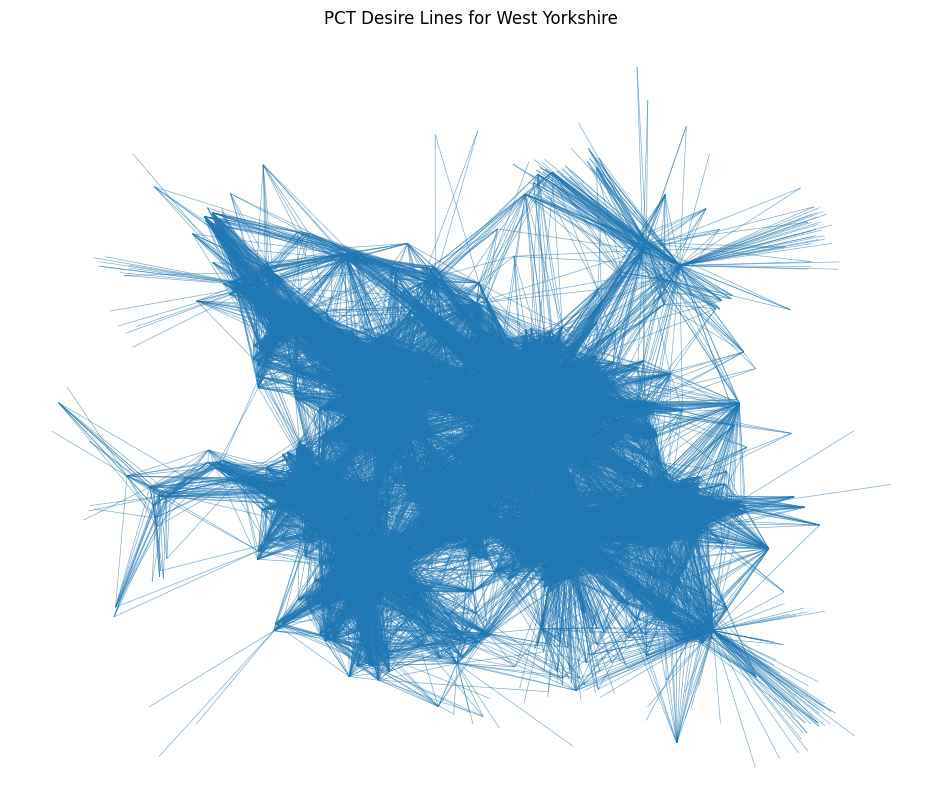

Total cycling trips: 8,146.0

Top 10 routes by cycling volume:


,bicycle
31480,15.0
37265,15.0
31380,12.0
31478,11.0
20313,9.0
25748,9.0
25750,9.0
27291,9.0
27365,9.0
31463,9.0


In [31]:
if leeds_desire_lines is not None:
    print(f"Found {len(leeds_desire_lines)} desire lines")
    
    # Plot desire lines
    leeds_desire_lines.plot(figsize=(14, 10), alpha=0.6, linewidth=0.5)
    plt.title("PCT Desire Lines for West Yorkshire")
    plt.axis('off')
    plt.show()
    
    # Show cycling statistics
    if 'bicycle' in leeds_desire_lines.columns:
        total_cycling = leeds_desire_lines['bicycle'].sum()
        print(f"Total cycling trips: {total_cycling:,}")
        
        # Show top routes by cycling volume
        print("\nTop 10 routes by cycling volume:")
        top_routes = leeds_desire_lines.nlargest(10, 'bicycle')[['bicycle']].round(2)
        display(top_routes)
else:
    print("❌ PCT desire lines not available")


## 5. LSOA Administrative Boundaries


Loaded 34753 LSOA boundaries
Total area covered: 151243.0 km²


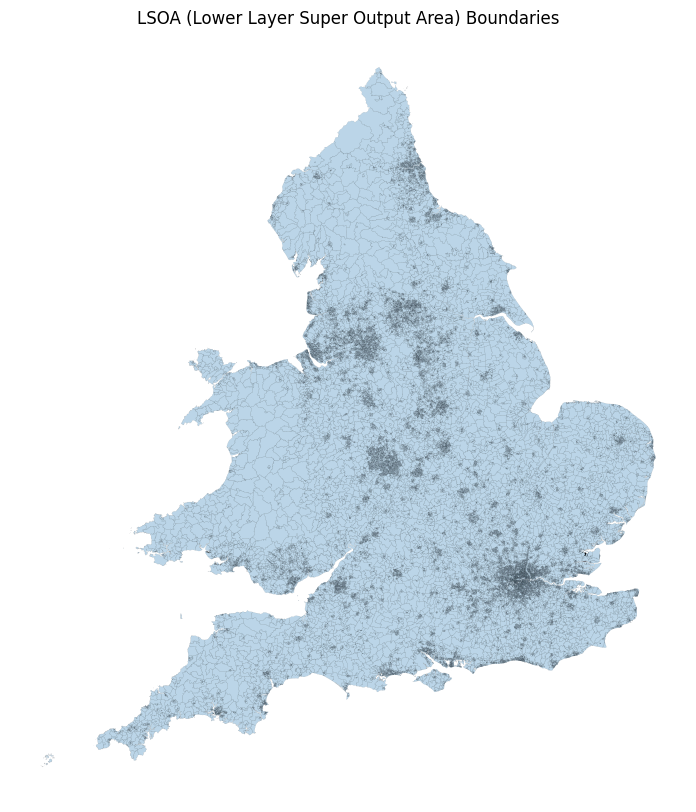


Sample of LSOA boundary data:


,LSOA11CD,LSOA11NM,BNG_E,BNG_N,LONG_,LAT,Shape_Leng,GlobalID,geometry
0,E01000001,City of London 001A,532123,181632,-0.097140,51.518200,2635.767993,{EAF9E4B8-FCC1-4CAE-A46C-22C8A43FF39B},"MULTIPOLYGON (((532151.537 181867.433, 532149...."
1,E01000002,City of London 001B,532480,181715,-0.091970,51.518799,2707.881853,{4434CA6E-E270-4E88-B3EB-4CFB37F62490},"MULTIPOLYGON (((532634.497 181926.016, 532632...."
2,E01000003,City of London 001C,532239,182033,-0.095320,51.521702,1224.638192,{D0FF9760-86DC-40DA-AD33-3B1DC987EF04},"MULTIPOLYGON (((532153.703 182165.155, 532149...."
3,E01000005,City of London 001E,533581,181283,-0.076270,51.514702,2275.805348,{474CAA9F-A6E3-4DE2-8BC1-2F5B0DA40271},"MULTIPOLYGON (((533619.062 181402.364, 533615...."
4,E01000006,Barking and Dagenham 016A,544994,184274,0.089317,51.538700,1966.092607,{FF2BC9A6-9E26-4415-9CEC-EAEA2C0A4F54},"MULTIPOLYGON (((545126.852 184310.838, 545125...."


In [27]:
if lsoa_boundaries is not None:
    print(f"Loaded {len(lsoa_boundaries)} LSOA boundaries")
    
    # Show basic info about the boundaries
    print(f"Total area covered: {lsoa_boundaries.geometry.area.sum()/1e6:.1f} km²")
    
    # Plot boundaries
    fig, ax = plt.subplots(figsize=(14, 10))
    lsoa_boundaries.plot(ax=ax, alpha=0.3, edgecolor='black', linewidth=0.1)
    ax.set_title("LSOA (Lower Layer Super Output Area) Boundaries")
    ax.axis('off')
    plt.show()
    
    # Show sample of boundary data
    print("\nSample of LSOA boundary data:")
    display(lsoa_boundaries.head())
    
else:
    print("❌ LSOA boundaries not available")
    print("To load LSOA boundaries, download the file and place it in the project directory")


## 6. Exercise: Year-over-Year Analysis (2019 vs 2020)


/tmp/ipykernel_125059/1375087243.py:31: DtypeWarning: Columns (0,2,35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


Year-over-year comparison:
2019 collisions: 117,536
2020 collisions: 91,199
Change from 2019 to 2020: -22.4%


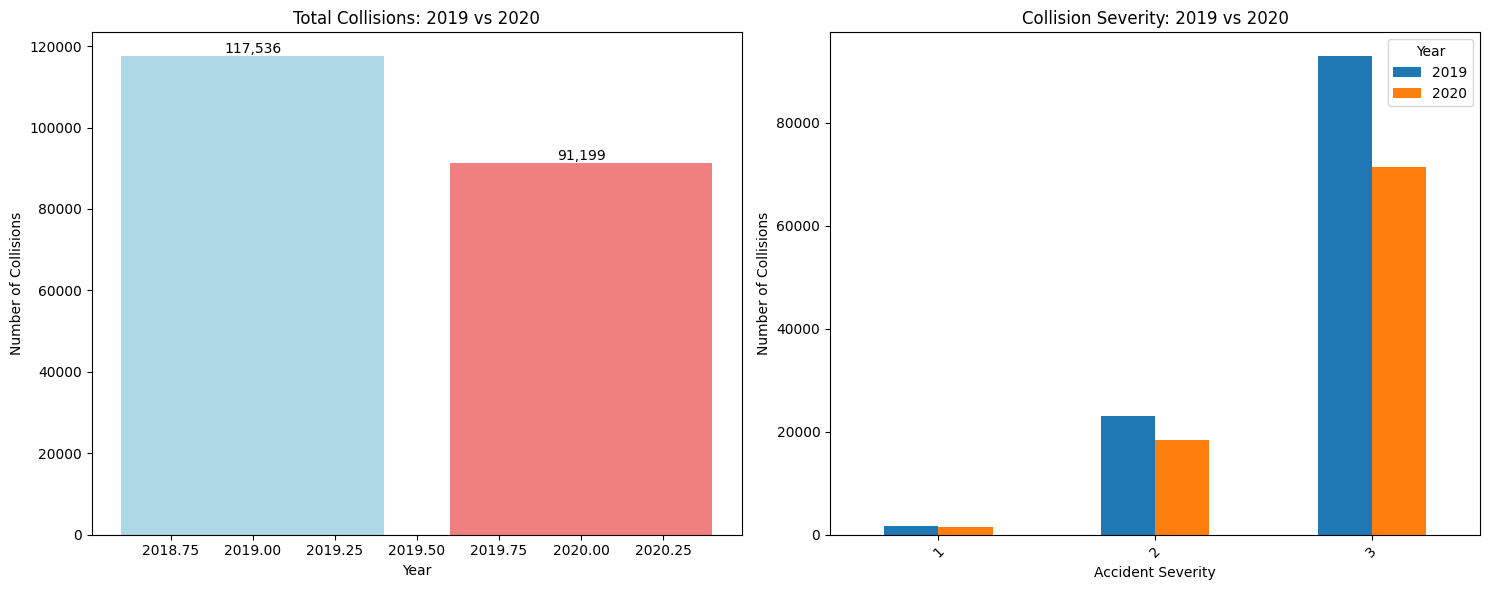


📊 Key Insights:
• Significant reduction in collisions in 2020 (likely due to COVID-19 lockdowns)
• This demonstrates the impact of reduced traffic on road safety
• Such analysis helps understand the relationship between traffic volume and accidents


In [28]:
# Download 2019 collision data for comparison
collisions_2019 = download_stats19_data(2019, "collision")

if collisions_2019 is not None and collisions is not None:
    print("Year-over-year comparison:")
    print(f"2019 collisions: {len(collisions_2019):,}")
    print(f"2020 collisions: {len(collisions):,}")
    
    # Calculate percentage change
    change = ((len(collisions) - len(collisions_2019)) / len(collisions_2019)) * 100
    print(f"Change from 2019 to 2020: {change:+.1f}%")
    
    # Create comparison visualization
    years = [2019, 2020]
    collision_counts = [len(collisions_2019), len(collisions)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart comparison
    bars = ax1.bar(years, collision_counts, color=['lightblue', 'lightcoral'])
    ax1.set_title('Total Collisions: 2019 vs 2020')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Collisions')
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}', ha='center', va='bottom')
    
    # Severity comparison if available
    if ('accident_severity' in collisions_2019.columns and 
        'accident_severity' in collisions.columns):
        
        severity_2019 = collisions_2019['accident_severity'].value_counts().sort_index()
        severity_2020 = collisions['accident_severity'].value_counts().sort_index()
        
        # Create comparison DataFrame
        severity_comparison = pd.DataFrame({
            '2019': severity_2019,
            '2020': severity_2020
        }).fillna(0)
        
        severity_comparison.plot(kind='bar', ax=ax2)
        ax2.set_title('Collision Severity: 2019 vs 2020')
        ax2.set_xlabel('Accident Severity')
        ax2.set_ylabel('Number of Collisions')
        ax2.legend(title='Year')
        ax2.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    print("\n📊 Key Insights:")
    print("• Significant reduction in collisions in 2020 (likely due to COVID-19 lockdowns)")
    print("• This demonstrates the impact of reduced traffic on road safety")
    print("• Such analysis helps understand the relationship between traffic volume and accidents")

else:
    print("❌ Need both 2019 and 2020 data for comparison")
